In [1]:
import os
import sys
import ursse.path_assistant as pa
shift = 'shift_06_17_2021'
from config_ursse import get_from_config
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
font = {'size'   : 18}
lines = {'linewidth': 3}
matplotlib.rc('font', **font)
matplotlib.rc('lines', **lines)
from scipy.optimize import curve_fit
iota_period_sec = get_from_config("IOTA_revolution_period")
from datetime import datetime
import pathlib

In [2]:
shift.get_shift_files()

['osc_evolution.ptu']

In [3]:
for i,f in enumerate(shift.get_shift_files()):
    print(f'Working on {f}, {i+1} out of {len(shift.get_shift_files())}')
    shift.generate_csv_cache(f)

Working on osc_evolution.ptu, 1 out of 1


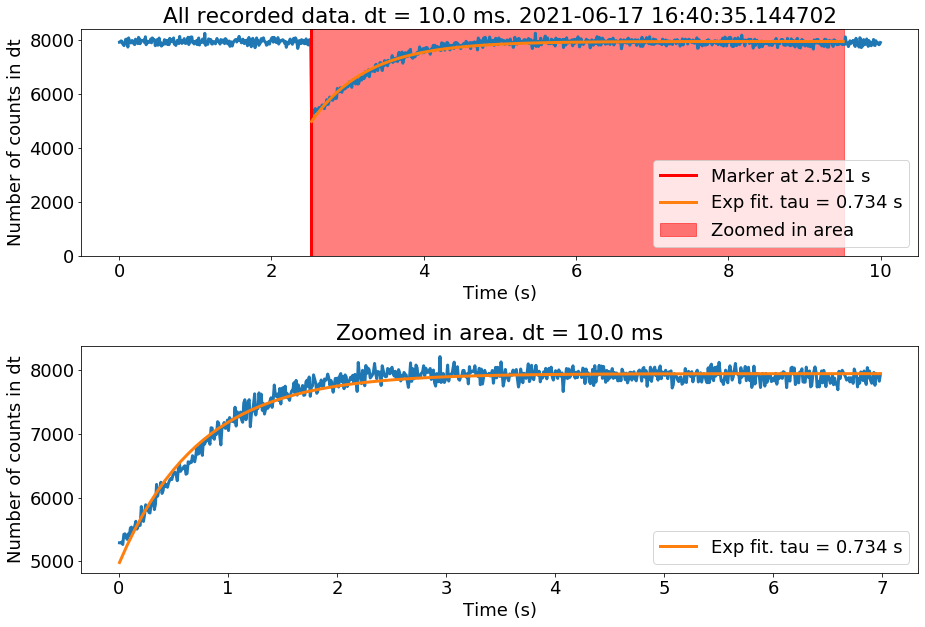

In [4]:
dt = 10e-3 # sec
t_zoom = 7# sec
tau0 = 1 # sec --- initial guess for the damping time

note = 'no_OSC_centered'
ptu_file = 'osc_evolution.ptu'
fname = pathlib.Path(shift.get_time_stamp_file_path(ptu_file))
mtime = datetime.fromtimestamp(fname.stat().st_mtime)

file_path = os.path.join(shift.time_stamp_files_folder_path, "cache", ptu_file[:-3] +'csv')


df0 = pd.read_csv(file_path)
marker_idx = df0[df0['channel'] == 5].index[0]
marker_time = df0.loc[marker_idx, 'revolution'] * iota_period_sec
df0 = df0[df0['channel'] == 2]
r0 = df0.loc[0, 'revolution']
df0['revolution'] -= r0
df0['time_sec'] = df0['revolution'] * iota_period_sec
marker_time -= r0 * iota_period_sec

def get_res(df0):
    ser = df0.groupby((df0['time_sec'] / dt).astype(int)).apply(lambda x: len(x.index))
    idx_span = ser.index[-1] - ser.index[0] + 1 
    time_idx = np.arange(idx_span)
    time_sec = dt/2 + dt * time_idx
    counts = np.zeros(shape=time_idx.shape)
    counts[ser.index - ser.index[0]] = ser.values
    res0 = pd.DataFrame({'time_sec': time_sec[:-1], 'counts': counts[:-1]})
    return res0

res0 = get_res(df0)

df = df0[(df0['time_sec'] > marker_time) & (df0['time_sec'] < marker_time + t_zoom)].copy().reset_index(drop=True)
t0 = df.loc[0, 'time_sec']
df['time_sec'] -= t0
res = get_res(df)


def f(x, tau, a, b):
    return a * np.exp(-x/tau) + b

b0 = res['counts'].max()
a0 = res['counts'].min() - b0
p0 = [tau0, b0, a0]
popt, pcov = curve_fit(f, res['time_sec'], res['counts'], p0=p0)
ts = np.linspace(res.loc[0,'time_sec'], res['time_sec'].iloc[-1], 100)

tau = popt[0]
fitlabel = f"Exp fit. tau = {tau:.3f} s"

fig, ax = plt.subplots(2,1, figsize=(15,10))
ax1, ax2 = ax
ax1.plot(res0['time_sec'], res0['counts'])
ax1.set_ylabel('Number of counts in dt')
ax1.set_xlabel('Time (s)')
ax1.axvline(marker_time, color='red', label=f'Marker at {marker_time:.3f} s')
ax1.axvspan(marker_time, marker_time + t_zoom, alpha=0.5, color='red', label='Zoomed in area')

ax1.set_title(f'All recorded data. dt = {1e3*dt:.1f} ms. {mtime}')
ax1.set_ylim(0, ax1.get_ylim()[1])

ax1.plot(ts+t0, f(ts, *popt), label=fitlabel)
ax1.legend(loc='lower right')

ax2.plot(res['time_sec'], res['counts'])
ax2.plot(ts, f(ts, *popt), label=fitlabel)
ax2.set_ylabel('Number of counts in dt')
ax2.set_xlabel('Time (s)')
ax2.set_title(f'Zoomed in area. dt = {1e3*dt:.1f} ms')
ax2.legend(loc='lower right')
plt.subplots_adjust(hspace=0.4)
fig.savefig(shift.get_results_dir().fi(note+'_'+f'source_file_date={mtime}'.replace(' ', '_')\
                                      .replace(':', '_').replace('.', '_'))+'.pdf',
            bbox_inches='tight')
plt.show()
res0.to_csv(shift.get_results_dir().fi(note+'_'+f'source_file_date={mtime}_marker={marker_time:.3f}s.csv'))